# Autoencoder

Set some global parameters

In [1]:
# Whether to rotate data in an orientation indiepndent manner or not.
USE_ORIENTATION_INDIPENDENT_TRANSFORMATION = False

# Whether to normalize data or not.
# Note: we usually do not normalize beacause the distance between points
# and reconstructed points gets reduced but the signal is not well represented
USE_NORMALIZATION = False

## Load dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers

from autoencoder_utils import show_samples, show_loss, show_mse, show_reconstructed_signals, show_reconstruction_errors
from keras_utils import ModelSaveCallback
from orientation_indipendend_transformation import orientation_independent_transformation

In [3]:
random.seed(42)
np.random.seed(42)

In [4]:
def load_dataset():
    data = pd.read_csv("./datasets/our2/dataset_50_2.5.csv", header=None, names=range(750))
    labels = pd.read_csv("./datasets/our2/dataset_labels_50_2.5.csv", header=None, names=["user", "model", "label"])

    return data, labels

In [5]:
def print_stats(ds: pd.DataFrame):
    print("Shape", ds.shape)
    print("Columns", ds.columns)

In [6]:
X_df_reference, y_df_reference = load_dataset()

In [7]:
print_stats(X_df_reference)
print_stats(y_df_reference)

Shape (22589, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (22589, 3)
Columns Index(['user', 'model', 'label'], dtype='object')


## Preprocessing

In [8]:
def get_label(x):
    return x[2]

In [9]:
def restructure(x):
    return x.reshape(-1, 6, 125)

In [10]:
def normalize(x):
    min_val = np.max(x)
    max_val = np.min(x)
    
    x = (x - min_val) / (max_val - min_val)
    
    return x

In [11]:
X_df, y_df = X_df_reference.copy(), y_df_reference.copy()

In [12]:

# *** MERGE LABELS
# Merge sit and stand labels
sit_or_stand_filter = (y_df["label"] == "sit") | (y_df["label"] == "stand")
y_df["label"].loc[sit_or_stand_filter] = "no_activity"

# Merge stairs activity
#stairsdown_or_stairsup_filter = (y_df["label"] == "stairsdown") | (y_df["label"] == "stairsup")
#y_df["label"].loc[stairsdown_or_stairsup_filter] = "stairs"

# *** SHUFFLE
X_shuffled_df = X_df.sample(frac=1)
y_shuffled_df = y_df.reindex(X_shuffled_df.index)

# *** TRAIN AND TEST
but_last_user_indicies = ~((y_df['user'] == "a") | (y_df['user'] == "b"))

X_train_df = X_shuffled_df.loc[but_last_user_indicies]
X_test_df = X_shuffled_df.loc[~but_last_user_indicies]

y_train_df = y_shuffled_df.loc[but_last_user_indicies]
y_test_df = y_shuffled_df.loc[~but_last_user_indicies]

print("X_train_df =", len(X_train_df))
print("X_test_df =", len(X_test_df))
print("y_train_df =", len(y_train_df))
print("y_test_df =", len(y_test_df))

assert len(X_train_df) == len(y_train_df), "X train and y train do not contain same number of samples"
assert len(X_test_df) == len(y_test_df), "X test and y test do not contain same number of samples"


X_train_df = 17409
X_test_df = 5180
y_train_df = 17409
y_test_df = 5180


In [13]:
# 1. Back to numpy
X_train = X_train_df.loc[:].to_numpy()
X_test = X_test_df.loc[:].to_numpy()

# 2. Restructure the array
X_train = restructure(X_train)
X_test = restructure(X_test)

# 3. Normalize
if USE_NORMALIZATION:
    X_train = normalize(X_train)
    X_test = normalize(X_test)

# 4. Orientation indipendent transformation
if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION:
    X_train = orientation_independent_transformation(X_train)
    X_test = orientation_independent_transformation(X_test)

# 5. Get ground thruth
y_train = y_train_df.loc[:].to_numpy()
y_test = y_test_df.loc[:].to_numpy()

# 6. One hot (for classification)
y_train_hot = pd.get_dummies(y_train_df['label']).to_numpy()
y_test_hot = pd.get_dummies(y_test_df['label']).to_numpy()

# 7. Keep only label
y_train = np.array(list(map(get_label, y_train)))
y_test = np.array(list(map(get_label, y_test)))

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17409, 6, 125)
(17409,)
(5180, 6, 125)
(5180,)


Labels

In [15]:
classes = np.unique(y_train)
num_classes = len(np.unique(y_train))

print(f"Classes = {classes}")
print(f"Num classes = {num_classes}")

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']
Num classes = 5


In [16]:
assert X_train.shape == (y_train.shape[0], 6, 125), f"Invalid shape of X_train: {X_train.shape}"
assert y_train.shape == (X_train.shape[0],), f"Invalid shape of y_train: {y_train.shape}"
assert X_test.shape == (y_test.shape[0], 6, 125), f"Invalid shape of X_test: {X_test.shape}"
assert y_test.shape == (X_test.shape[0],), f"Invalid shape of y_test: {y_test.shape}"
assert y_train_hot.shape == (y_train.shape[0],num_classes), f"Invalid shape of y_train_hot: {y_train_hot.shape}"
assert y_test_hot.shape == (y_test.shape[0],num_classes), f"Invalid shape of y_test_hot: {y_test_hot.shape}"

Plot some samples

X[0]: bike


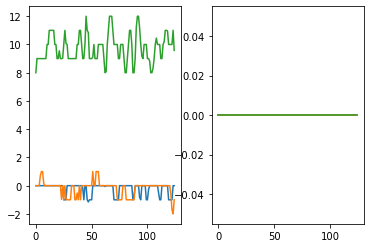

In [17]:
show_samples(X_train, y_train, n=1, is_random=False)

## Data Exploration

In [18]:
print("Users", y_df["user"].unique())
print("Models", y_df["model"].unique())
print("Classes", y_df["label"].unique())

Users ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i']
Models ['nexus4_1' 'nexus4_2' 's3_1' 's3_2' 's3mini_1' 's3mini_2']
Classes ['no_activity' 'walk' 'stairsup' 'stairsdown' 'bike']


Fraction of samples per label

In [19]:
print(y_df.groupby(["label"])["label"].count() / y_df["label"].count())

label
bike           0.139714
no_activity    0.368941
stairsdown     0.118155
stairsup       0.151445
walk           0.221745
Name: label, dtype: float64


Fraction of samples per user

In [20]:
print(y_df.groupby(["user"])["user"].count() / y_df["user"].count())

user
a    0.113949
b    0.115366
c    0.101465
d    0.114480
e    0.120413
f    0.094781
g    0.113285
h    0.107353
i    0.118907
Name: user, dtype: float64


Fraction of samples per model

In [21]:
print(y_df.groupby(["model"])["model"].count() / y_df["model"].count())

model
nexus4_1    0.198105
nexus4_2    0.211342
s3_1        0.187171
s3_2        0.206029
s3mini_1    0.190137
s3mini_2    0.007216
Name: model, dtype: float64


Number of samples per user i and fraction of samples per class for user i

In [22]:
y_df_i = y_df.loc[y_df["user"] == "i"]

num_samples_i = y_df_i["label"].count()
fraction_of_samples_per_class_i = y_df_i.groupby(["label"])["label"].count() / y_df_i["label"].count()

print(num_samples_i)
print(fraction_of_samples_per_class_i)

2686
label
bike           0.164557
no_activity    0.380491
stairsdown     0.119509
stairsup       0.099032
walk           0.236411
Name: label, dtype: float64


## Model (autoencoder)

X[0]: bike


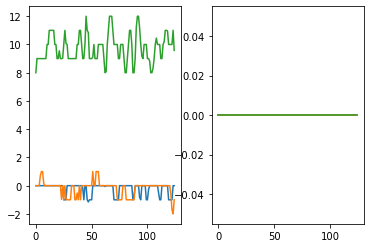

In [23]:
show_samples(X_train, y_train, n=1, is_random=False)

In [24]:
DATA_SHAPE = X_train.shape[1:]
CODE_SIZE=30

In [25]:
def build_encoder(data_shape, code_size):
    inputs = tf.keras.Input(data_shape)

    X = inputs    
    X = layers.Flatten()(X)
    X = layers.Dense(150, activation="relu")(X)
    X = layers.Dense(code_size, activation="sigmoid")(X)
    outputs = X
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [26]:

def build_decoder(data_shape, code_size):
    inputs = tf.keras.Input((code_size,))

    X = inputs
    X = layers.Dense(150, activation="relu")(X)
    X = layers.Dense(np.prod(data_shape), activation=None)(X)
    outputs = layers.Reshape(data_shape)(X)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [27]:
def build_autoencoder(encoder, decoder):
    inputs = tf.keras.Input(DATA_SHAPE)  # input
    codes = encoder(inputs)              # build the code with the encoder
    outputs = decoder(codes)             # reconstruction the signal with the decoder

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [28]:
encoder = build_encoder(DATA_SHAPE, CODE_SIZE)
decoder = build_decoder(DATA_SHAPE, CODE_SIZE)

In [29]:
autoencoder = build_autoencoder(encoder, decoder)

optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=200
batch_size=128

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
save_model_checkpoint_callback = ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

autoencoder.compile(optimizer=optimizer, loss=loss)

history = autoencoder.fit(
    x=X_train, y=X_train, 
    epochs=epochs, 
    validation_data=(X_test, X_test), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1)

Epoch 1/200
137/137 [==============================] - 1s 5ms/step - loss: 4.9194 - val_loss: 2.5887
Epoch 2/200
137/137 [==============================] - 1s 4ms/step - loss: 1.3676 - val_loss: 1.7872
Epoch 3/200
137/137 [==============================] - 1s 4ms/step - loss: 1.3121 - val_loss: 1.7065
Epoch 4/200
137/137 [==============================] - 1s 4ms/step - loss: 1.3026 - val_loss: 1.6545
Epoch 5/200
137/137 [==============================] - 0s 4ms/step - loss: 1.2969 - val_loss: 1.6608
Epoch 6/200
137/137 [==============================] - 0s 4ms/step - loss: 1.3021 - val_loss: 1.6590
Epoch 7/200
137/137 [==============================] - 1s 4ms/step - loss: 1.2808 - val_loss: 1.7610
Epoch 8/200
137/137 [==============================] - 1s 4ms/step - loss: 1.2444 - val_loss: 1.5282
Epoch 9/200
137/137 [==============================] - 1s 4ms/step - loss: 1.1697 - val_loss: 1.4624
Epoch 10/200
137/137 [==============================] - 0s 4ms/step - loss: 1.1461 - val_lo

In [30]:
encoder.save("encoder.h5")

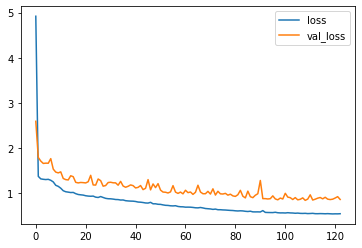

In [31]:
show_loss(history)

In [32]:
show_mse(autoencoder, X_test)

MSE = 0.8557036519050598


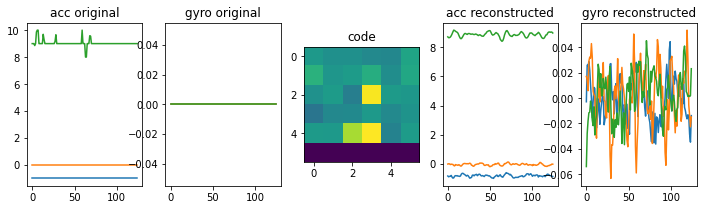

In [33]:
show_reconstructed_signals(X_test, encoder, decoder, n=1)

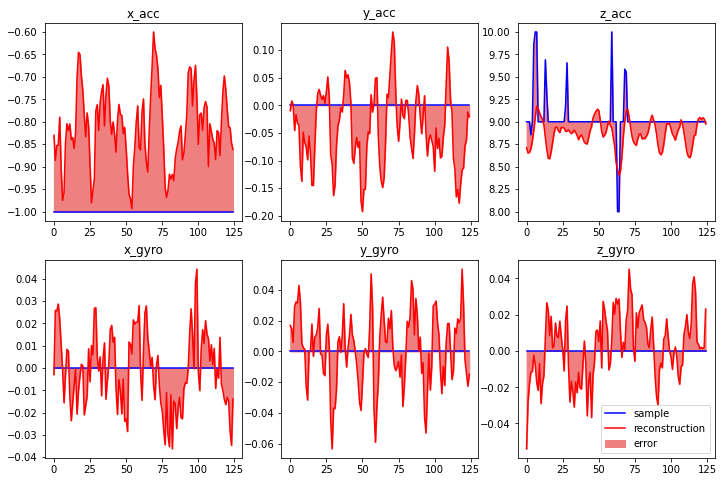

In [34]:
show_reconstruction_errors(X_test, encoder, decoder, n=1)

## KNN classifier

In [35]:
from sklearn.neighbors import KNeighborsClassifier

# prepare the codes
codes = encoder.predict(X_train)

assert codes.shape[1:] == (CODE_SIZE,), f"Predicted codes shape must be equal to code size, but {codes.shape[1:]} != {(CODE_SIZE,)}"

# create the k-neighbors calssifier
n_neighbors = num_classes
metric = "euclidean"

nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

# fit the model using the codes
nbrs.fit(codes, y_train)

KNeighborsClassifier(metric='euclidean')

In [36]:
print("Classes =", nbrs.classes_)

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']


In [37]:
print("X_test[i] = y_true \t y_pred    \t with probs [...]")
print()

for i in range(20):
    x = X_test[i]
    y = y_test[i]

    c = encoder.predict(x[np.newaxis, :])[0]
    
    [lab] = nbrs.predict(c[np.newaxis, :])
    [probs] = nbrs.predict_proba(c[np.newaxis, :])

    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")


X_test[i] = y_true 	 y_pred    	 with probs [...]

X_test[0] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[1] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[2] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[3] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[4] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[5] = stairsup	 stairsup   	 with probs [0.2 0.  0.2 0.6 0. ]
X_test[6] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[7] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[8] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[9] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[10] = stairsup	 stairsup   	 with probs [0. 0. 0. 1. 0.]
X_test[11] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[12] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[13] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]


In [38]:
from sklearn.metrics import classification_report

codes = encoder.predict(X_test)

y_true = y_test
y_pred = nbrs.predict(codes)

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.53      0.76      0.62       815
 no_activity       0.87      0.78      0.82      1820
  stairsdown       0.98      0.63      0.76       627
    stairsup       0.79      0.47      0.59       832
        walk       0.67      0.92      0.78      1086

    accuracy                           0.74      5180
   macro avg       0.77      0.71      0.72      5180
weighted avg       0.78      0.74      0.74      5180



## KMeans classifier

In [39]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()
le.fit(y_test)

# train
codes = encoder.predict(X_train)

kmeans = KMeans(n_clusters=num_classes, random_state=0)
kmeans.fit(codes)

# evaluate 
codes = encoder.predict(X_test)

y_true = y_test
y_pred = le.inverse_transform(kmeans.predict(codes))

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.24      0.07      0.11       815
 no_activity       0.00      0.00      0.00      1820
  stairsdown       0.05      0.04      0.05       627
    stairsup       0.03      0.06      0.04       832
        walk       0.23      0.39      0.29      1086

    accuracy                           0.11      5180
   macro avg       0.11      0.11      0.10      5180
weighted avg       0.10      0.11      0.09      5180



## NN classifier

In [40]:
def build_nn(code_size):
    inputs = tf.keras.Input((code_size,))
    X = inputs
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(num_classes, activation="softmax")(X)
    outputs = X

    return tf.keras.Model(inputs=inputs, outputs=outputs)

filepath = f'models/encoder_oit_cs48-bs128.h5'
encoder = tf.keras.models.load_model(filepath)

codes_train = encoder.predict(X_train)
codes_test = encoder.predict(X_test)

nn_model = build_nn(48)

adam_optimizer = tf.keras.optimizers.Adam()
loss_funct = tf.keras.losses.CategoricalCrossentropy()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callbacks = [early_stopping_callback]

nn_model.compile(optimizer=adam_optimizer, loss=loss_funct, metrics=["accuracy"])
nn_model.summary()

history = nn_model.fit(x=codes_train, y=y_train_hot,
    epochs=50,
    validation_data=(codes_test, y_test_hot), 
    batch_size=128,
    callbacks=callbacks,
    verbose=1)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               4900      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 15,505
Trainable params: 15,505
Non-trainable params: 0
__________________________________________________

162/162 [==============================] - 0s 655us/step - loss: 2.0432 - accuracy: 0.6008
LOSS = 2.0431606769561768
ACCURACY = 0.6007722020149231


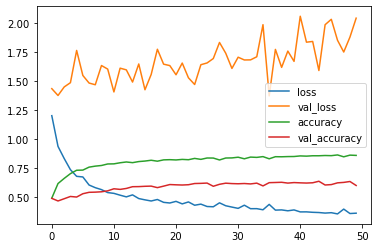

In [41]:
from sklearn.metrics import accuracy_score

loss, accuracy = nn_model.evaluate(codes_test, y_test_hot)

print("LOSS =", loss)
print("ACCURACY =", accuracy)

show_loss(history)

# Grid Search


In [42]:
#def build_classifier():
#    # prepare the codes
#    codes = encoder.predict(X_train)
#
#    assert codes.shape[1:] == (CODE_SIZE,), f"Predicted codes shape must be equal to code size, but {codes.shape[1:]} != {(CODE_SIZE,)}"
#
#    # create the k-neighbors calssifier
#    n_neighbors = num_classes
#    metric = "euclidean"
#
#    nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
#
#    # fit the model using the codes
#    nbrs.fit(codes, y_train)


def compile_autoencoder(autoencoder, hparams):
    """
    Compile autoencoder with given hyperparams.
    """

    optimizer = hparams["optimizer"]
    loss = hparams["loss_func"]

    autoencoder.compile(optimizer=optimizer, loss=loss)

    return autoencoder


def fit_autoencoder(autoencoder, hparams):
    """
    Fit the autoencoder with given hyperparams on `X_train` with validation `X_test`.
    Please note that the best and last models are saved in `models` folder.
    """

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    callbacks = [early_stopping_callback]

    history = autoencoder.fit(
        x=X_train, y=X_train, 
        epochs=hparams["epochs"], 
        validation_data=(X_test, X_test), 
        batch_size=hparams["batch_size"],
        callbacks=callbacks,
        verbose=0)

    return history


def evaluate_autoencoder(autoencoder):
    """
    Evaluate the autoencoder with `X_test`.
    """
    return autoencoder.evaluate(X_test, X_test, verbose=0)


def run_model(hparams):
    """
    Setup, train and evaluate the autoencoder model with given hyperparams.

    :return: A tuple `(loss, hystory)`
    """
    encoder = build_encoder(DATA_SHAPE, hparams["code_size"])
    decoder = build_decoder(DATA_SHAPE, hparams["code_size"])

    autoencoder = build_autoencoder(encoder, decoder)
    autoencoder = compile_autoencoder(autoencoder, hparams)

    history = fit_autoencoder(autoencoder, hparams)
    loss = evaluate_autoencoder(autoencoder)

    # Note: we may also add the classifier training and evaluation 
    #       to select the best model

    filepath = f'models/encoder_{ "oit_" if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION else "" }cs{hparams["code_size"]}-bs{hparams["batch_size"]}.h5'
    encoder.save(filepath)

    return loss, history


def select_model():
    """
    Run the model with hyperparams and save results.

    :return: An array of results with mse, hparams and training history.
    """
    results = []

    hparams_code_sizes = [6, 12, 18, 30, 48, 54, 60, 72]
    hparams_opts = ["adam"]
    hparams_losses = ["mse"]
    hparams_epochs = [150]
    hparams_batch_sizes = [32, 128]

    for code_size in hparams_code_sizes:
        for opt in hparams_opts:
            for loss in hparams_losses:
                for epochs in hparams_epochs:
                    for batch_size in hparams_batch_sizes:

                        hparams = {
                            "code_size": code_size,
                            "optimizer": opt,
                            "loss_func": loss,
                            "epochs": epochs,
                            "batch_size": batch_size
                        }

                        print(f"Starting new run with hparams =", hparams)
                    
                        mse, history = run_model(hparams)

                        print(f"HPARAMS = {hparams}")
                        print(f"MSE = {mse}")
                        print()

                        results += [{"hparams": hparams, "mse": mse, "history": history}]

    return results

Select the best model based on lowest loss.

In [43]:
import time

start = time.time()
results = select_model()
end = time.time()

print(f"Done in {end - start} s")

Starting new run with hparams = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32}
HPARAMS = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32}
MSE = 1.971874475479126

Starting new run with hparams = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128}
HPARAMS = {'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128}
MSE = 1.4285799264907837

Starting new run with hparams = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32}
HPARAMS = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32}
MSE = 1.379479169845581

Starting new run with hparams = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128}
HPARAMS = {'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128}
MSE = 1.373723149299

Print a CSV table for models and save them to file

In [44]:
def get_csv(results):
    s = "i,mse,hparams,filepath\n"
    
    for i, result in zip(range(len(results)), results):
        hparams = result["hparams"]
        code_size = hparams["code_size"]
        batch_size = hparams["batch_size"]
        mse = result["mse"]

        filepath = f'models/encoder_{ "oit_" if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION else "" }cs{code_size}-bs{batch_size}.h5'

        s += f"{i},{mse},{hparams},{filepath}\n"
    
    return s


def save_results(results, filename=f'models/res{ "_oit" if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION else "" }.csv.txt'):
    with open(filename, mode="w") as f:
        content = get_csv(results)
        f.write(content)


print(get_csv(results))
save_results(results)

i,mse,hparams,filepath
0,1.971874475479126,{'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32},models/encoder_cs6-bs32.h5
1,1.4285799264907837,{'code_size': 6, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128},models/encoder_cs6-bs128.h5
2,1.379479169845581,{'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32},models/encoder_cs12-bs32.h5
3,1.3737231492996216,{'code_size': 12, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128},models/encoder_cs12-bs128.h5
4,0.967420220375061,{'code_size': 18, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32},models/encoder_cs18-bs32.h5
5,1.0020891427993774,{'code_size': 18, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 128},models/encoder_cs18-bs128.h5
6,0.9317409992218018,{'code_size': 30, 'optimizer': 'adam', 'loss_func': 'mse', 'epochs': 150, 'batch_size': 32},models/encoder_cs30

Let's check whether loaded model MSE differs from the MSE calculated in the grid search. They should not be different.

Plot some results from hparams

In [45]:
#losses_by_code_size_with_batch_32 = list(map(lambda r: r["hparams"]["code_size"], list(filter(lambda r: r["hparams"]["batch_size"] == 32, results)))), #list(map(lambda r: r["mse"], list(filter(lambda r: r["hparams"]["batch_size"] == 32, results))))
#losses_by_code_size_with_batch_128 = list(map(lambda r: r["hparams"]["code_size"], list(filter(lambda r: r["hparams"]["batch_size"] == 128, results))))#, list(map(lambda r: r["mse"], list(filter(lambda r: r["hparams"]["batch_size"] == 128, results))))
#losses_by_code_size_with_batch_256 = list(map(lambda r: r["hparams"]["code_size"], list(filter(lambda r: r["hparams"]["batch_size"] == 256, results))))#, list(map(lambda r: r["mse"], list(filter(lambda r: r["hparams"]["batch_size"] == 256, results))))
#
#
#plt.scatter(losses_by_code_size_with_batch_32[0], losses_by_code_size_with_batch_32[1])
#plt.scatter(losses_by_code_size_with_batch_128[0], losses_by_code_size_with_batch_128[1])
#plt.scatter(losses_by_code_size_with_batch_256[0], losses_by_code_size_with_batch_256[1])
#plt.show()